In [ ]:
!uv pip install -q equinox cifar10-web

In [ ]:
from jaxtyping import Array, Float, Int, PyTree  # https://github.com/google/jaxtyping
from jax import grad, jit
import jax.numpy as jnp
import jax

import equinox as eqx

import numpy as np

from cifar10_web import cifar10

import matplotlib.pyplot as plt

from functools import partial

In [ ]:
X_train, train_labels, X_test, test_labels = cifar10(path=None)
X_test = X_test.reshape(X_test.shape[0],3,32,32).transpose(0,2,3,1)
X_train = X_train.reshape(X_train.shape[0],3,32,32).transpose(0,2,3,1)


X_train, X_test = map(np.array, [X_train,X_test])
mean = X_train.mean(axis=(0,1,2)).reshape(1,1,1,-1)
std = X_train.std(axis=(0,1,2)).reshape(1,1,1,-1)

X_train = (X_train - mean)/std
X_test = (X_test - mean)/std

Downloaded cifar-10-binary.tar.gz to /root/data/cifar10


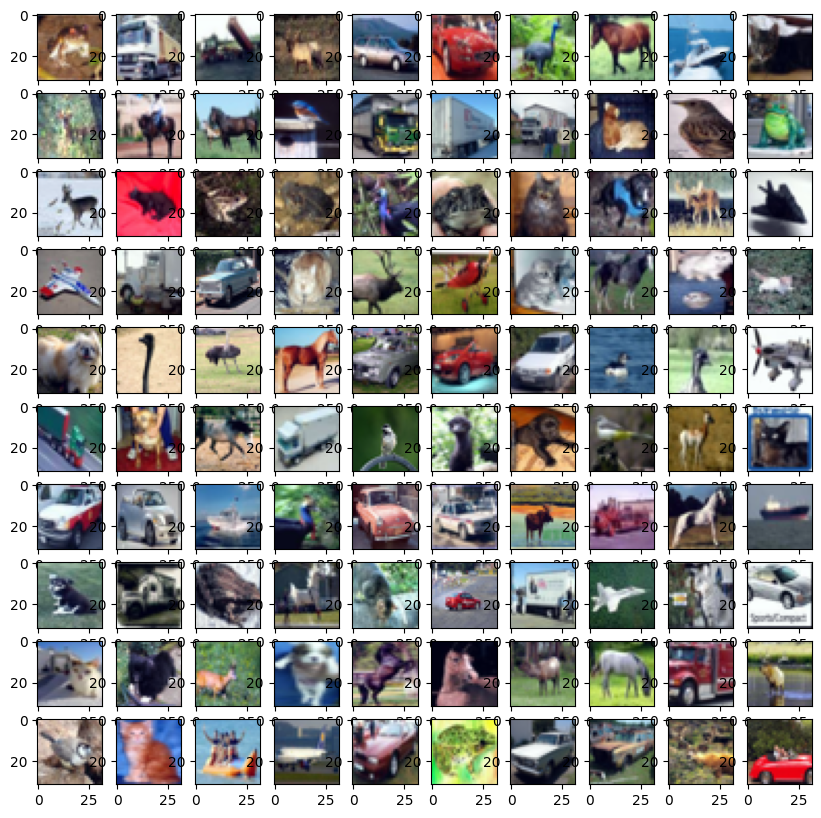

In [ ]:
plt.figure(figsize=(10,10))
for _i in range(100):
    plt.subplot(10,10,_i+1)
    _img = X_train[_i] - X_train[_i].min()
    plt.imshow(_img/_img.max())

plt.show()

In [ ]:
X_train_noisy = X_train + 0.5*np.random.randn(*X_train.shape)
X_test_noisy = X_test + 0.5*np.random.randn(*X_test.shape)

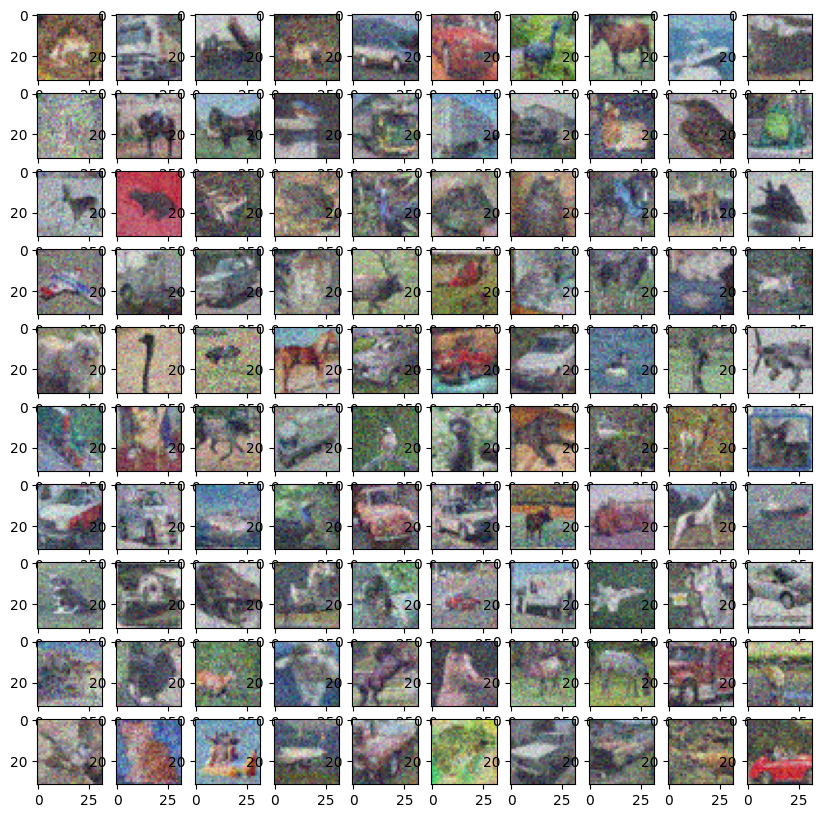

In [ ]:
plt.figure(figsize=(10,10))
for _i in range(100):
    plt.subplot(10,10,_i+1)
    _img = X_train_noisy[_i] - X_train_noisy[_i].min()
    plt.imshow(_img/_img.max())

plt.show()

In [ ]:
class Encoder(eqx.Module):
    layers : list
    def __init__(self,key):
        keys = jax.random.split(key, 4)

        self.layers = [

            eqx.nn.Conv2d(3,20,kernel_size=2,key=keys[0]),
            jax.nn.relu,
            eqx.nn.MaxPool2d(kernel_size=2),

            eqx.nn.Conv2d(20,20,kernel_size=2,key=keys[1]),
            jax.nn.relu,
            eqx.nn.MaxPool2d(kernel_size=2),

            eqx.nn.Conv2d(20,20,kernel_size=2,key=keys[2]),
            jax.nn.relu,
            eqx.nn.MaxPool2d(kernel_size=2),

            eqx.nn.Conv2d(20,10,kernel_size=2,key=keys[3]),
            jax.nn.relu,
            eqx.nn.MaxPool2d(kernel_size=2),
        ]

    def __call__(self, x: Float[Array,"1 32 32"]):
        for layer in self.layers:
            x = layer(x)
        return x

In [ ]:
class Decoder(eqx.Module):
    layers : list
    def __init__(self,key):
        keys = jax.random.split(key, 9)

        self.layers = [

            eqx.nn.ConvTranspose2d(10,20,kernel_size=2,stride=(1,1),padding=1,key=keys[0]),
            jax.nn.relu,

            eqx.nn.ConvTranspose2d(20,20,kernel_size=2,key=keys[1]),
            jax.nn.relu,


            eqx.nn.ConvTranspose2d(20,20,kernel_size=2,stride=(1,1),key=keys[2]),
            jax.nn.relu,


            eqx.nn.ConvTranspose2d(20,20,kernel_size=2,key=keys[3]),
            jax.nn.relu,

            eqx.nn.ConvTranspose2d(20,20,kernel_size=2,key=keys[4]),
            jax.nn.relu,

            eqx.nn.ConvTranspose2d(20,20,kernel_size=2,key=keys[5]),
            jax.nn.relu,

            eqx.nn.ConvTranspose2d(20,20,kernel_size=2,stride=(1,1),key=keys[6]),
            jax.nn.relu,


            eqx.nn.ConvTranspose2d(20,20,kernel_size=2,key=keys[7]),
            jax.nn.relu,

            eqx.nn.ConvTranspose2d(20,20,kernel_size=2,key=keys[8]),
            jax.nn.relu,

            eqx.nn.ConvTranspose2d(20,3,kernel_size=2,key=keys[9]),
            jax.nn.tanh,

        ]

    def __call__(self, x: Float[Array,"1 32 32"]):
        for layer in self.layers:
            x = layer(x)
        return x

In [ ]:
class Autoencoder(eqx.Module):
    layers : list
    def __init__(self, key):
        enckey, deckey = jax.random.split(key)
        self.layers  = [
            Encoder(enckey),
            Decoder(deckey)
        ]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x*3

In [ ]:
key = jax.random.PRNGKey(0)
model0 = Autoencoder(key)

m=jax.vmap(model0.layers[0])(X_train[:77].transpose(0,3,1,2))
m.shape,jax.vmap(model0.layers[1])(m).shape

((77, 10, 24, 24), (77, 3, 32, 32))

In [ ]:
jax.vmap(model0)(X_train[:77].transpose(0,3,1,2)).shape

(77, 3, 32, 32)

In [ ]:
_model = Autoencoder(jax.random.PRNGKey(32))


def lossfn(model, xnoisy, x):
    xnoisy = xnoisy.transpose(0,3,1,2)
    x = x.transpose(0,3,1,2)

    xhat = jax.vmap(model)(xnoisy)

    loss = jnp.sum((xhat - x)**2)/x.shape[0]

    return loss

# @jit
def predict(model, x):
    x = x.transpose(2,0,1)
    out = model(x)
    out = out.transpose(1,2,0)
    return out

dlossfn = eqx.filter_grad(lossfn)

print(lossfn(_model, X_train_noisy[:10], X_train[:10]))

3287.3743


In [ ]:
import optax
from tqdm import tqdm

key1 = jax.random.PRNGKey(42)
model1 = Autoencoder(key1)

batchsize = 700
epochs = 200
pbar = tqdm(range(epochs), ncols=90)


optimizers = [optax.adamax, optax.adam, optax.novograd, optax.adagrad, optax.adamw, optax.novograd, optax.adafactor]
lrs = [1e-3, 1e-4]

optimizer = optax.amsgrad(learning_rate=5e-3)#, weight_decay=1e-4)
opt_state = optimizer.init(eqx.filter(model1, eqx.is_array))

for _i in pbar:
    # optimizer = np.random.choice(optimizers)(learning_rate=np.random.choice(lrs))
    # opt_state = optimizer.init(eqx.filter(model1, eqx.is_array))
    for _b in range(0,X_train.shape[0],batchsize):
        xnoise_batch = X_train_noisy[_b:_b+batchsize]
        x_batch = X_train[_b:_b+batchsize]

        grads = dlossfn(model1,xnoise_batch,x_batch)
        # print(x_batch.shape,xnoise_batch.shape)

        updates, opt_state = optimizer.update(
            grads, opt_state, eqx.filter(model1, eqx.is_array)
        )

        model1 = eqx.apply_updates(model1, updates)

        if np.random.rand()>0.25:
            pbar.set_postfix({"loss":f"{lossfn(model1, xnoise_batch, x_batch):.4f}"})

  0%|                                             | 0/200 [23:57<?, ?it/s, loss=1776.7616]

In [ ]:
_imgid = np.random.randint(300)
print(_imgid)
# _imgid = 16

_img = predict(model1, X_test_noisy[_imgid])
_img *= std[0]
_img -= _img.min()
_img /= _img.max()


plt.subplot(1,3,1)
plt.imshow(_img)

plt.subplot(1,3,2)
_img = X_test_noisy[_imgid]*std[0] + mean[0]
_img -= _img.min()
_img /= _img.max()
plt.imshow(_img)

plt.subplot(1,3,3)
_img = X_test[_imgid]*std[0] + mean[0]
_img -= _img.min()
_img /= _img.max()
plt.imshow(_img)